<a href="https://colab.research.google.com/github/ayushs0911/Practice/blob/main/Pytorch_Cat_Vs_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Dataset : [Source](https://www.kaggle.com/c/dogs-vs-cats/data)

In [2]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:12<00:00, 71.0MB/s]


In [3]:
train_dir = "/content/train"
test_dir = "/content/test1"

In [4]:
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
len(train_files), len(test_files)

(25000, 12500)

In [5]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

/content/train/dog.2055.jpg


In [6]:
transformations = transforms.Compose([
    transforms.Resize((60,60)),
    transforms.ToTensor()
    ])

Creating a dataset class that stories our dataset information(paths, labels and transformations)

The object can then be utilised by torch functions such as `torch.utils.data.random_split`

This code defines a class called `Dataset` that represents a dataset of images. It is designed to be used with PyTorch, a popular deep learning framework.

The `Dataset` class has the following attributes:

- `filelist`: A list containing the names of the image files in the dataset.
- `filepath`: The path to the directory where the image files are located.
- `transform`: An optional parameter that represents an image transformation function. This function can be used to apply preprocessing or data augmentation techniques to the images.

The class has three main methods:

1. `__init__(self, filelist, filepath, transform=None)`: This is the constructor method that initializes the `Dataset` object. It takes three parameters: `filelist`, `filepath`, and `transform`. The `filelist` parameter is used to store the list of image file names, the `filepath` parameter represents the directory path where the image files are located, and the `transform` parameter is an optional argument that represents the image transformation function.

2. `__len__(self)`: This method returns the length of the dataset, which is the number of images in the `filelist`. It is used to enable the dataset to be iterable.

3. `__getitem__(self, index)`: This method is used to retrieve a specific item from the dataset. It takes an `index` parameter, which indicates the position of the item to be retrieved. The method first constructs the complete path to the image file by joining the `filepath` and the name of the file from `filelist`. It then opens the image using the `Image.open()` function. Next, it checks if the string "dog" is present in the image path. If it is, the label is set to 1, indicating it is a dog image; otherwise, the label is set to 0, indicating it is not a dog image. Finally, if a transformation function is provided, it applies the transformation to the image and returns a tuple containing the transformed image and the label.

Overall, this `Dataset` class provides a convenient way to load and preprocess image data for machine learning tasks using PyTorch. It allows easy access to individual images and their corresponding labels, as well as the flexibility to apply custom image transformations if needed.

In [7]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [8]:
train = Dataset(train_files, train_dir, transformations)
test = Dataset(test_files, test_dir, transformations)

In [9]:
train.__len__()

25000

In [10]:
train.__getitem__(0)

(tensor([[[0.8078, 0.7608, 0.6353,  ..., 0.7647, 0.8196, 0.8314],
          [0.7922, 0.6941, 0.6392,  ..., 0.6392, 0.6392, 0.6471],
          [0.6824, 0.6235, 0.6078,  ..., 0.7176, 0.6353, 0.5569],
          ...,
          [0.2471, 0.2824, 0.3098,  ..., 0.4902, 0.4314, 0.4510],
          [0.2431, 0.3176, 0.3529,  ..., 0.6706, 0.5333, 0.4235],
          [0.3137, 0.3882, 0.3137,  ..., 0.6471, 0.7451, 0.4902]],
 
         [[0.8431, 0.8275, 0.6824,  ..., 0.7608, 0.8039, 0.8039],
          [0.8549, 0.7843, 0.7216,  ..., 0.6353, 0.6392, 0.6392],
          [0.7608, 0.7569, 0.7294,  ..., 0.7020, 0.6275, 0.5686],
          ...,
          [0.3569, 0.3961, 0.4078,  ..., 0.6392, 0.6078, 0.6588],
          [0.3882, 0.3922, 0.4039,  ..., 0.7294, 0.6392, 0.6039],
          [0.4078, 0.4039, 0.4078,  ..., 0.6784, 0.7647, 0.6196]],
 
         [[0.6314, 0.5451, 0.4510,  ..., 0.7412, 0.7882, 0.7922],
          [0.6471, 0.5373, 0.4667,  ..., 0.6392, 0.6353, 0.6353],
          [0.4902, 0.4549, 0.4196,  ...,

In [11]:
# Getting the shape of a single image
print(test.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


**Using our dataset object to create train, val split**

In [12]:
train, val = torch.utils.data.random_split(train, [20000, 5000])

In [13]:
len(train), len(val)

(20000, 5000)

In [14]:
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

## Dataloaders - let's create our iterable over a dataset. 

In [15]:
train_dataset = torch.utils.data.DataLoader(dataset = train,
                                            batch_size = 32, 
                                            shuffle = True)
val_dataset = torch.utils.data.DataLoader(val, 
                                          batch_size = 32, 
                                          shuffle = True)

#data visualization 

In [16]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize = (16,24))
grid_image = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_image.numpy()

<Figure size 1600x2400 with 0 Axes>

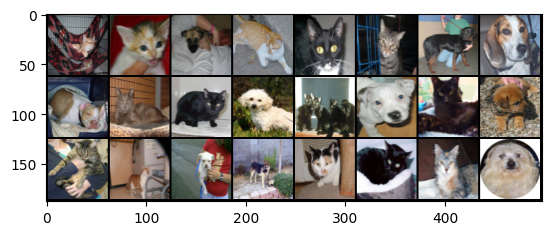

In [17]:
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

#Building Model

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            ) 
            
        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        ) 

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )
            
        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1) 

In [20]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

In [21]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

# Train the model 


 1. Initialization of lists: `train_loss`, `train_accuracy`, `val_loss`, and `val_accuracy` are empty lists that will be used to store the training and validation loss and accuracy values for each epoch.

2. Loop over epochs: The code begins a loop over a specified number of epochs. During each epoch, the model will be trained on the training dataset.

3. Model training: Inside the epoch loop, the model is put in training mode (`model.train()`). Several variables are initialized: `total`, `correct`, `counter`, and `train_running_loss`. `total` keeps track of the total number of labeled instances seen so far, `correct` tracks the number of correctly predicted instances, `counter` keeps count of the iterations, and `train_running_loss` accumulates the training loss across all iterations in the epoch.

4. Progress bar setup: The code sets up a progress bar (`tqdm`) with the training dataset as an iterable. It displays the current epoch number and the total number of epochs.

5. Training iteration: The code iterates through the training dataset using a for loop. Each iteration fetches a batch of data (`data`) and its corresponding labels (`label`). The data and labels are moved to the device (e.g., GPU) if available.

6. Forward and backward pass: The optimizer's gradients are zeroed (`optimiser.zero_grad()`), and the model's output is computed by passing the data through the model (`output = model(data)`). The loss is then calculated using a specified criterion (`loss = criterion(output, label)`). Backpropagation is performed by calling `loss.backward()`, and the optimizer updates the model's parameters using `optimiser.step()`.

7. Loss and accuracy calculation: The training loss for the current batch is multiplied by the batch size and added to `train_running_loss`. The predicted labels (`pred`) are compared to the true labels (`label`) to calculate the number of correct predictions (`correct`). The total number of labeled instances (`total`) is incremented by the batch size.

8. Epoch-level metrics: At the end of each epoch, the accuracy and loss for that epoch are computed by dividing the total number of correct predictions (`correct`) by the total number of labeled instances (`total`). These values are appended to `train_accuracy` and `train_loss`, respectively. The epoch number, training accuracy, and training loss are printed.

9. Validation: After every few epochs (in this case, when `epoch % 1 == 0`), the model is put in evaluation mode (`model.eval()`). The code then proceeds to evaluate the model on the validation dataset.

10. Validation iteration: Similar to the training iteration, the code iterates over the validation dataset and performs forward pass and loss calculation for each batch.

11. Validation metrics: The validation loss is computed by multiplying the loss value by the batch size and accumulating it in `val_running_loss`. The number of correct predictions and the total number of labeled instances are updated (`correct` and `total`, respectively).

12. Epoch-level metrics (validation): Similar to the training metrics, the validation accuracy and loss for the epoch are calculated by dividing the total number of correct predictions (`correct`) by the total number of labeled instances (`total`). These values are appended to `val_accuracy` and `val_loss`, respectively. The epoch number, validation accuracy, and validation loss are printed.

The loop continues for the specified number of epochs, and after the loop completes, the `train_loss`, `train_accuracy`, `val_loss`, and `val_accuracy` lists will contain the training and validation metrics for each epoch

In [22]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes 
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step() 

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-22-ed1d14d94d43>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.58865
Epoch 1 Training Loss = 21.269278688049315
Epoch 1 Validation Accuracy = 0.6712
Epoch 1 Validation Loss = 19.57732780420097


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.69365
Epoch 2 Training Loss = 19.144193492126465
Epoch 2 Validation Accuracy = 0.7024
Epoch 2 Validation Loss = 18.640342250751083


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.72575
Epoch 3 Training Loss = 18.22787368774414
Epoch 3 Validation Accuracy = 0.718
Epoch 3 Validation Loss = 18.222222603050767


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.75365
Epoch 4 Training Loss = 17.401209072875975
Epoch 4 Validation Accuracy = 0.679
Epoch 4 Validation Loss = 19.491694114770098


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7702
Epoch 5 Training Loss = 16.940259315490724
Epoch 5 Validation Accuracy = 0.753
Epoch 5 Validation Loss = 17.370153050513785


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.78415
Epoch 6 Training Loss = 16.540692092895508
Epoch 6 Validation Accuracy = 0.7696
Epoch 6 Validation Loss = 16.851177810863327


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.79675
Epoch 7 Training Loss = 16.18627487487793
Epoch 7 Validation Accuracy = 0.7764
Epoch 7 Validation Loss = 16.62394909646101


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.8049
Epoch 8 Training Loss = 15.983040158081055
Epoch 8 Validation Accuracy = 0.7792
Epoch 8 Validation Loss = 16.584193457463744


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.81585
Epoch 9 Training Loss = 15.648119171142579
Epoch 9 Validation Accuracy = 0.7864
Epoch 9 Validation Loss = 16.42142232664072


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.8247
Epoch 10 Training Loss = 15.389280499267578
Epoch 10 Validation Accuracy = 0.7858
Epoch 10 Validation Loss = 16.481714623748875


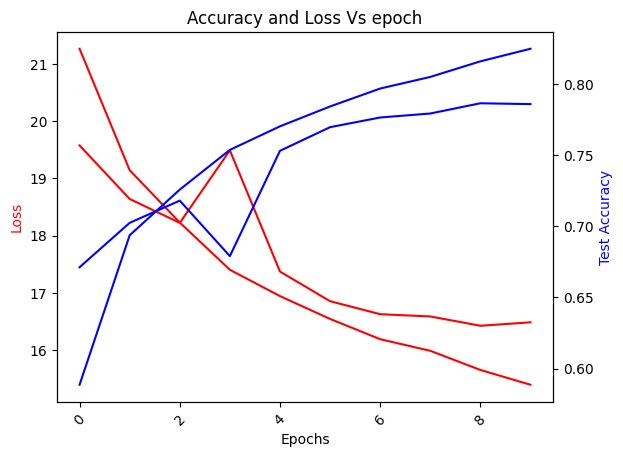

In [24]:
epoch_log = [*range(epochs)]

#to create a plot with secondary y-axis we need to create a subplot 
fig, ax1 = plt.subplots()

#set title and x-axis label rotation 
plt.title("Accuracy and Loss Vs epoch")
plt.xticks(rotation = 45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()


In [25]:
PATH = "/content/cat_vs_dogs_10_epochs.pth"
torch.save(model.state_dict(), PATH)

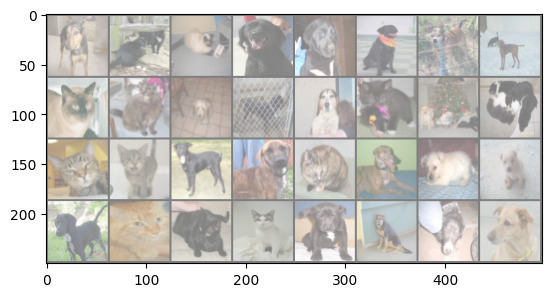

GroundTruth:  10011111001110110011011110001111


In [27]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Loading one mini-batch
images, labels = next(iter(train_dataset))


# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(32)))

In [28]:
model = CNN()
model.to(device)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

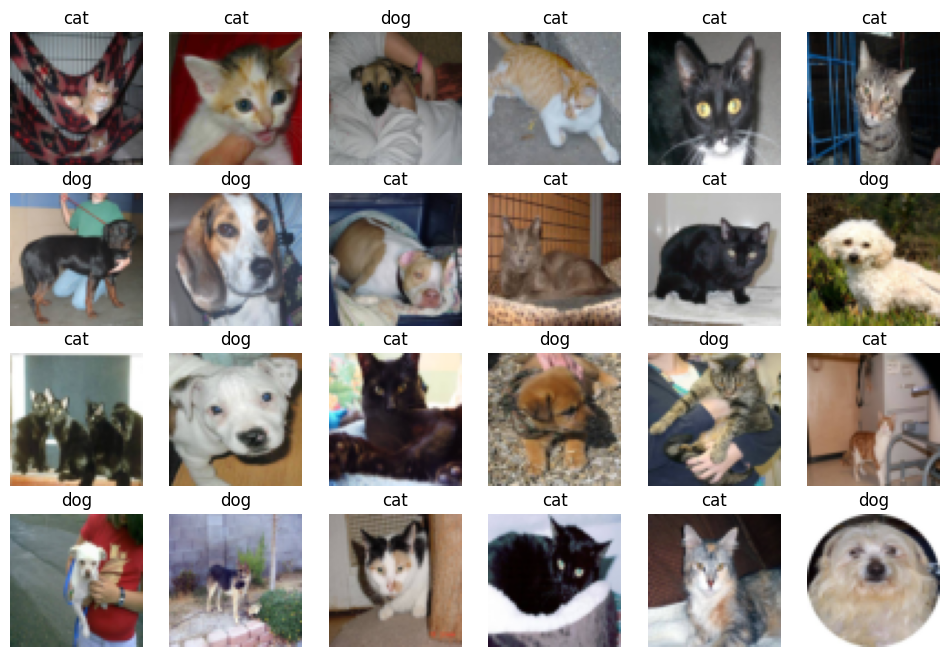

In [31]:
images, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))